In [2]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [3]:
set_config(transform_output="pandas") 

In [4]:
# load the data

data = fetch_california_housing(as_frame=True)

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
# make X and y

X, y = data.data, data.target

In [7]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [10]:
X.shape

(20640, 8)

In [11]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


## Model

In [12]:
# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [13]:
# fit the training data
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


### HP Tuning

In [15]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [16]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-08-24 18:42:12,536] A new study created in memory with name: no-name-98c69682-73f7-48f2-8609-7122914e508e
Best trial: 3. Best value: 0.819638:   2%|▏         | 1/50 [00:03<03:04,  3.76s/it]

[I 2025-08-24 18:42:16,460] Trial 3 finished with value: 0.8196383290448757 and parameters: {'learning_rate': 0.2433573659535948, 'n_estimators': 231, 'max_depth': 10, 'reg_lambda': 69.30341003833531, 'gamma': 1.852068231835573, 'subsample': 0.8562439253082397}. Best is trial 3 with value: 0.8196383290448757.


Best trial: 4. Best value: 0.834996:   6%|▌         | 3/50 [00:12<02:53,  3.70s/it]

[I 2025-08-24 18:42:25,190] Trial 0 finished with value: 0.8078101138389784 and parameters: {'learning_rate': 0.054954306516998744, 'n_estimators': 418, 'max_depth': 3, 'reg_lambda': 23.61947261954903, 'gamma': 0.6257112988944995, 'subsample': 0.8015628110368167}. Best is trial 3 with value: 0.8196383290448757.
[I 2025-08-24 18:42:25,322] Trial 4 finished with value: 0.8349958272921926 and parameters: {'learning_rate': 0.2706875950974211, 'n_estimators': 252, 'max_depth': 8, 'reg_lambda': 63.264382790236866, 'gamma': 0.8110907291392906, 'subsample': 0.810709666136322}. Best is trial 4 with value: 0.8349958272921926.


Best trial: 2. Best value: 0.844642:   8%|▊         | 4/50 [00:20<04:02,  5.28s/it]

[I 2025-08-24 18:42:33,045] Trial 2 finished with value: 0.8446417658914637 and parameters: {'learning_rate': 0.07915530259912258, 'n_estimators': 198, 'max_depth': 9, 'reg_lambda': 27.719624997759375, 'gamma': 0.263086014975779, 'subsample': 0.7122288381321635}. Best is trial 2 with value: 0.8446417658914637.


Best trial: 1. Best value: 0.845195:  12%|█▏        | 6/50 [00:26<02:39,  3.63s/it]

[I 2025-08-24 18:42:38,698] Trial 1 finished with value: 0.8451951075835107 and parameters: {'learning_rate': 0.04623927399405345, 'n_estimators': 236, 'max_depth': 10, 'reg_lambda': 29.67661917705132, 'gamma': 0.1697805749184067, 'subsample': 0.9712638685723995}. Best is trial 1 with value: 0.8451951075835107.
[I 2025-08-24 18:42:38,878] Trial 5 finished with value: 0.8445036349642212 and parameters: {'learning_rate': 0.1251525299061571, 'n_estimators': 140, 'max_depth': 8, 'reg_lambda': 32.95558717540479, 'gamma': 0.16074508621374495, 'subsample': 0.8393284509989732}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  14%|█▍        | 7/50 [00:29<02:25,  3.38s/it]

[I 2025-08-24 18:42:41,727] Trial 7 finished with value: 0.8236877715312356 and parameters: {'learning_rate': 0.2969286139594344, 'n_estimators': 396, 'max_depth': 8, 'reg_lambda': 75.42090646181478, 'gamma': 1.3978042922322025, 'subsample': 0.7703911289737411}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  16%|█▌        | 8/50 [00:29<01:43,  2.46s/it]

[I 2025-08-24 18:42:42,213] Trial 6 finished with value: 0.7986534378700243 and parameters: {'learning_rate': 0.02807088392513192, 'n_estimators': 210, 'max_depth': 6, 'reg_lambda': 72.12499467056107, 'gamma': 1.9837067680805294, 'subsample': 0.7310797261530594}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  18%|█▊        | 9/50 [00:39<03:16,  4.78s/it]

[I 2025-08-24 18:42:52,091] Trial 11 finished with value: 0.8329031567514084 and parameters: {'learning_rate': 0.10286957874149831, 'n_estimators': 199, 'max_depth': 5, 'reg_lambda': 34.15237710157475, 'gamma': 0.4709751196849088, 'subsample': 0.8239559274505677}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  20%|██        | 10/50 [00:40<02:31,  3.79s/it]

[I 2025-08-24 18:42:53,676] Trial 9 finished with value: 0.7860884317932688 and parameters: {'learning_rate': 0.026339381498304545, 'n_estimators': 302, 'max_depth': 4, 'reg_lambda': 76.63888427331662, 'gamma': 1.9945200644846313, 'subsample': 0.9917314324168827}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  22%|██▏       | 11/50 [00:48<03:10,  4.88s/it]

[I 2025-08-24 18:43:01,016] Trial 12 finished with value: 0.8062043434180508 and parameters: {'learning_rate': 0.16271081344195407, 'n_estimators': 149, 'max_depth': 3, 'reg_lambda': 30.59167727510788, 'gamma': 0.5878330808216541, 'subsample': 0.7720584625070087}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  24%|██▍       | 12/50 [00:56<03:44,  5.92s/it]

[I 2025-08-24 18:43:09,317] Trial 13 finished with value: 0.8221011858192201 and parameters: {'learning_rate': 0.19741232399469125, 'n_estimators': 331, 'max_depth': 10, 'reg_lambda': 6.01000085555021, 'gamma': 1.221948549319726, 'subsample': 0.9863342180544581}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 1. Best value: 0.845195:  26%|██▌       | 13/50 [01:07<04:38,  7.53s/it]

[I 2025-08-24 18:43:20,568] Trial 15 finished with value: 0.7990890772192916 and parameters: {'learning_rate': 0.07863649049916696, 'n_estimators': 50, 'max_depth': 9, 'reg_lambda': 98.26119124940399, 'gamma': 0.035774253091906294, 'subsample': 0.9214210093994164}. Best is trial 1 with value: 0.8451951075835107.


Best trial: 10. Best value: 0.845488:  28%|██▊       | 14/50 [01:14<04:24,  7.34s/it]

[I 2025-08-24 18:43:27,453] Trial 10 finished with value: 0.8454879536439176 and parameters: {'learning_rate': 0.27446780440920704, 'n_estimators': 491, 'max_depth': 7, 'reg_lambda': 99.79746685466634, 'gamma': 0.10283690425012293, 'subsample': 0.815267006880069}. Best is trial 10 with value: 0.8454879536439176.


Best trial: 10. Best value: 0.845488:  30%|███       | 15/50 [01:16<03:20,  5.72s/it]

[I 2025-08-24 18:43:29,434] Trial 14 finished with value: 0.8364129211912997 and parameters: {'learning_rate': 0.08057678268540815, 'n_estimators': 331, 'max_depth': 10, 'reg_lambda': 4.306279772667832, 'gamma': 0.09935677663800316, 'subsample': 0.9745892532510981}. Best is trial 10 with value: 0.8454879536439176.
[I 2025-08-24 18:43:29,532] Trial 16 finished with value: 0.831511150099252 and parameters: {'learning_rate': 0.07825659669385499, 'n_estimators': 75, 'max_depth': 10, 'reg_lambda': 9.566153069591085, 'gamma': 0.31974332077323103, 'subsample': 0.9080341189367246}. Best is trial 10 with value: 0.8454879536439176.


Best trial: 10. Best value: 0.845488:  34%|███▍      | 17/50 [01:33<03:51,  7.02s/it]

[I 2025-08-24 18:43:46,483] Trial 19 finished with value: 0.8276277758974722 and parameters: {'learning_rate': 0.20707855054281232, 'n_estimators': 493, 'max_depth': 6, 'reg_lambda': 53.43762538526708, 'gamma': 1.0694302099419928, 'subsample': 0.8839432546159947}. Best is trial 10 with value: 0.8454879536439176.


Best trial: 10. Best value: 0.845488:  36%|███▌      | 18/50 [01:34<02:51,  5.37s/it]

[I 2025-08-24 18:43:46,863] Trial 17 finished with value: 0.8435922797596669 and parameters: {'learning_rate': 0.21306216775023992, 'n_estimators': 352, 'max_depth': 6, 'reg_lambda': 96.2230142095836, 'gamma': 0.3571254054464643, 'subsample': 0.8883991961940805}. Best is trial 10 with value: 0.8454879536439176.


Best trial: 10. Best value: 0.845488:  38%|███▊      | 19/50 [01:38<02:39,  5.16s/it]

[I 2025-08-24 18:43:51,434] Trial 18 finished with value: 0.8412808513823306 and parameters: {'learning_rate': 0.2002820347342963, 'n_estimators': 479, 'max_depth': 6, 'reg_lambda': 51.928787810037534, 'gamma': 0.42531670583468867, 'subsample': 0.8900488460017872}. Best is trial 10 with value: 0.8454879536439176.


Best trial: 8. Best value: 0.851982:  40%|████      | 20/50 [01:43<02:32,  5.07s/it] 

[I 2025-08-24 18:43:56,261] Trial 8 finished with value: 0.8519822702647475 and parameters: {'learning_rate': 0.07265841699337261, 'n_estimators': 465, 'max_depth': 10, 'reg_lambda': 73.27268001764351, 'gamma': 0.0055691163900106755, 'subsample': 0.9953681609027367}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  42%|████▏     | 21/50 [01:50<02:39,  5.50s/it]

[I 2025-08-24 18:44:02,854] Trial 21 finished with value: 0.8292648255855358 and parameters: {'learning_rate': 0.14789522230694857, 'n_estimators': 472, 'max_depth': 7, 'reg_lambda': 47.6379970961644, 'gamma': 0.8596220137849045, 'subsample': 0.9342181107932863}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  44%|████▍     | 22/50 [01:50<01:52,  4.01s/it]

[I 2025-08-24 18:44:03,159] Trial 20 finished with value: 0.828889428249368 and parameters: {'learning_rate': 0.149715895492457, 'n_estimators': 482, 'max_depth': 7, 'reg_lambda': 98.91220406191158, 'gamma': 0.8057537634532439, 'subsample': 0.9531186995585152}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  46%|████▌     | 23/50 [01:54<01:47,  3.98s/it]

[I 2025-08-24 18:44:07,055] Trial 22 finished with value: 0.830256465782828 and parameters: {'learning_rate': 0.1493976073974041, 'n_estimators': 452, 'max_depth': 7, 'reg_lambda': 42.18402814631695, 'gamma': 0.8122730985887716, 'subsample': 0.9470304666413367}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  48%|████▊     | 24/50 [02:01<02:05,  4.82s/it]

[I 2025-08-24 18:44:13,913] Trial 23 finished with value: 0.8309022779805332 and parameters: {'learning_rate': 0.1455770936208163, 'n_estimators': 444, 'max_depth': 7, 'reg_lambda': 84.34085107564037, 'gamma': 0.8285234221905518, 'subsample': 0.9413314218277691}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  50%|█████     | 25/50 [02:32<05:12, 12.49s/it]

[I 2025-08-24 18:44:44,717] Trial 25 finished with value: 0.8481285271114893 and parameters: {'learning_rate': 0.039660764450577715, 'n_estimators': 423, 'max_depth': 9, 'reg_lambda': 88.24662027353972, 'gamma': 0.06327838682557241, 'subsample': 0.9503473054871524}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  52%|█████▏    | 26/50 [02:33<03:38,  9.11s/it]

[I 2025-08-24 18:44:45,824] Trial 24 finished with value: 0.8482473334372079 and parameters: {'learning_rate': 0.04032973482174324, 'n_estimators': 431, 'max_depth': 9, 'reg_lambda': 86.13752968643138, 'gamma': 0.02553932170836737, 'subsample': 0.9564688958111098}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  54%|█████▍    | 27/50 [02:34<02:38,  6.90s/it]

[I 2025-08-24 18:44:47,508] Trial 26 finished with value: 0.8501891052050186 and parameters: {'learning_rate': 0.04741125965295522, 'n_estimators': 409, 'max_depth': 9, 'reg_lambda': 85.7410561972544, 'gamma': 0.011436972118395172, 'subsample': 0.958491433670386}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  56%|█████▌    | 28/50 [02:39<02:15,  6.17s/it]

[I 2025-08-24 18:44:51,953] Trial 27 finished with value: 0.8231892872625733 and parameters: {'learning_rate': 0.016247949199696052, 'n_estimators': 384, 'max_depth': 9, 'reg_lambda': 86.4006014540709, 'gamma': 0.016769467230414392, 'subsample': 0.9667844916121942}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 8. Best value: 0.851982:  58%|█████▊    | 29/50 [02:54<03:03,  8.76s/it]

[I 2025-08-24 18:45:06,799] Trial 31 finished with value: 0.8332458486087153 and parameters: {'learning_rate': 0.108348860850568, 'n_estimators': 379, 'max_depth': 9, 'reg_lambda': 61.855473177440494, 'gamma': 0.5550916459589742, 'subsample': 0.9959046858054931}. Best is trial 8 with value: 0.8519822702647475.


Best trial: 28. Best value: 0.855655:  60%|██████    | 30/50 [03:13<03:57, 11.85s/it]

[I 2025-08-24 18:45:25,891] Trial 28 finished with value: 0.8556552029676148 and parameters: {'learning_rate': 0.10999689265565749, 'n_estimators': 385, 'max_depth': 9, 'reg_lambda': 88.46177239498388, 'gamma': 0.02645856382872991, 'subsample': 0.8674889914196615}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  62%|██████▏   | 31/50 [03:13<02:39,  8.40s/it]

[I 2025-08-24 18:45:26,195] Trial 29 finished with value: 0.8234089721236879 and parameters: {'learning_rate': 0.01670510150571955, 'n_estimators': 370, 'max_depth': 9, 'reg_lambda': 87.33380522433478, 'gamma': 0.019979000658180153, 'subsample': 0.9641660790829064}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  64%|██████▍   | 32/50 [03:15<01:55,  6.41s/it]

[I 2025-08-24 18:45:27,946] Trial 30 finished with value: 0.7978900023376144 and parameters: {'learning_rate': 0.010198496237374163, 'n_estimators': 374, 'max_depth': 9, 'reg_lambda': 84.65187818483813, 'gamma': 0.009226907769858668, 'subsample': 0.9993048602619595}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  66%|██████▌   | 33/50 [03:22<01:51,  6.56s/it]

[I 2025-08-24 18:45:34,860] Trial 32 finished with value: 0.8467559628267605 and parameters: {'learning_rate': 0.05957868638588239, 'n_estimators': 418, 'max_depth': 8, 'reg_lambda': 79.00668636527506, 'gamma': 0.25439786273374265, 'subsample': 0.9074566868885764}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  68%|██████▊   | 34/50 [03:31<01:57,  7.36s/it]

[I 2025-08-24 18:45:44,086] Trial 33 finished with value: 0.8457689777607021 and parameters: {'learning_rate': 0.061485058553121655, 'n_estimators': 297, 'max_depth': 8, 'reg_lambda': 79.63989099148897, 'gamma': 0.20685342727568698, 'subsample': 0.8607805535496202}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  70%|███████   | 35/50 [03:37<01:43,  6.92s/it]

[I 2025-08-24 18:45:49,981] Trial 34 finished with value: 0.848257726600906 and parameters: {'learning_rate': 0.06675293773762014, 'n_estimators': 429, 'max_depth': 8, 'reg_lambda': 79.31667414810119, 'gamma': 0.24914726062380163, 'subsample': 0.8709034062636044}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  72%|███████▏  | 36/50 [03:38<01:13,  5.26s/it]

[I 2025-08-24 18:45:51,360] Trial 35 finished with value: 0.8477377433673261 and parameters: {'learning_rate': 0.05854046041390633, 'n_estimators': 411, 'max_depth': 8, 'reg_lambda': 77.4698410717947, 'gamma': 0.24702985156254942, 'subsample': 0.9152330005752445}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  74%|███████▍  | 37/50 [03:48<01:27,  6.73s/it]

[I 2025-08-24 18:46:01,533] Trial 37 finished with value: 0.8215032141764416 and parameters: {'learning_rate': 0.10077915614850128, 'n_estimators': 421, 'max_depth': 10, 'reg_lambda': 93.39025113287633, 'gamma': 1.546309515302671, 'subsample': 0.9251041942719472}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  76%|███████▌  | 38/50 [03:54<01:17,  6.48s/it]

[I 2025-08-24 18:46:07,428] Trial 36 finished with value: 0.8489940823677349 and parameters: {'learning_rate': 0.058210092809798206, 'n_estimators': 450, 'max_depth': 10, 'reg_lambda': 67.12217393890057, 'gamma': 0.2243586709930404, 'subsample': 0.8709433620337282}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  78%|███████▊  | 39/50 [03:59<01:04,  5.84s/it]

[I 2025-08-24 18:46:11,768] Trial 39 finished with value: 0.8452641301836256 and parameters: {'learning_rate': 0.11325985013434828, 'n_estimators': 458, 'max_depth': 10, 'reg_lambda': 66.1462675852516, 'gamma': 0.4111088911214925, 'subsample': 0.8648956538009176}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  80%|████████  | 40/50 [04:01<00:47,  4.78s/it]

[I 2025-08-24 18:46:14,086] Trial 38 finished with value: 0.8458250253313649 and parameters: {'learning_rate': 0.09327921679977522, 'n_estimators': 404, 'max_depth': 10, 'reg_lambda': 64.66456855126468, 'gamma': 0.2787541937074847, 'subsample': 0.8675789959960272}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  82%|████████▏ | 41/50 [04:04<00:38,  4.23s/it]

[I 2025-08-24 18:46:17,018] Trial 40 finished with value: 0.8448260282190987 and parameters: {'learning_rate': 0.11639056395697837, 'n_estimators': 456, 'max_depth': 10, 'reg_lambda': 65.16473719250061, 'gamma': 0.38915410639828435, 'subsample': 0.8630340981398434}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  84%|████████▍ | 42/50 [04:15<00:51,  6.39s/it]

[I 2025-08-24 18:46:28,458] Trial 42 finished with value: 0.8383838668983902 and parameters: {'learning_rate': 0.1277377300665218, 'n_estimators': 346, 'max_depth': 10, 'reg_lambda': 56.86239551288912, 'gamma': 0.6910089687800561, 'subsample': 0.795417939190533}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  86%|████████▌ | 43/50 [04:20<00:40,  5.80s/it]

[I 2025-08-24 18:46:32,854] Trial 41 finished with value: 0.8463129605615041 and parameters: {'learning_rate': 0.09430152474679783, 'n_estimators': 453, 'max_depth': 10, 'reg_lambda': 66.04376828397898, 'gamma': 0.41419222104295544, 'subsample': 0.8385592409013823}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  88%|████████▊ | 44/50 [04:34<00:50,  8.36s/it]

[I 2025-08-24 18:46:47,202] Trial 43 finished with value: 0.8511604063368172 and parameters: {'learning_rate': 0.12719463748522025, 'n_estimators': 335, 'max_depth': 10, 'reg_lambda': 70.66414624348468, 'gamma': 0.1670629569528904, 'subsample': 0.8390564459658473}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  90%|█████████ | 45/50 [04:43<00:42,  8.41s/it]

[I 2025-08-24 18:46:55,734] Trial 44 finished with value: 0.848536053892701 and parameters: {'learning_rate': 0.04868651966116841, 'n_estimators': 351, 'max_depth': 9, 'reg_lambda': 58.132141826154594, 'gamma': 0.16278215514764427, 'subsample': 0.8340377975910764}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  92%|█████████▏| 46/50 [04:45<00:27,  6.77s/it]

[I 2025-08-24 18:46:58,668] Trial 46 finished with value: 0.8488961619230522 and parameters: {'learning_rate': 0.07004783233749542, 'n_estimators': 259, 'max_depth': 9, 'reg_lambda': 71.92659316608653, 'gamma': 0.1606429682268923, 'subsample': 0.8800730074457022}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  94%|█████████▍| 47/50 [04:55<00:22,  7.64s/it]

[I 2025-08-24 18:47:08,360] Trial 45 finished with value: 0.8512549854717459 and parameters: {'learning_rate': 0.0681242359095536, 'n_estimators': 439, 'max_depth': 9, 'reg_lambda': 71.13654979238692, 'gamma': 0.18230023591600025, 'subsample': 0.8309302924537842}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  96%|█████████▌| 48/50 [04:55<00:10,  5.42s/it]

[I 2025-08-24 18:47:08,594] Trial 47 finished with value: 0.8511794015660654 and parameters: {'learning_rate': 0.1283377454600298, 'n_estimators': 255, 'max_depth': 9, 'reg_lambda': 74.11139659217956, 'gamma': 0.15387366394217336, 'subsample': 0.832797388133568}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655:  98%|█████████▊| 49/50 [05:01<00:05,  5.40s/it]

[I 2025-08-24 18:47:13,928] Trial 48 finished with value: 0.85058598297442 and parameters: {'learning_rate': 0.13657028964231613, 'n_estimators': 263, 'max_depth': 9, 'reg_lambda': 69.54959208905503, 'gamma': 0.1541467939112594, 'subsample': 0.8502822911788581}. Best is trial 28 with value: 0.8556552029676148.


Best trial: 28. Best value: 0.855655: 100%|██████████| 50/50 [05:02<00:00,  6.06s/it]

[I 2025-08-24 18:47:15,584] Trial 49 finished with value: 0.8493984397017009 and parameters: {'learning_rate': 0.16892153506356378, 'n_estimators': 321, 'max_depth': 10, 'reg_lambda': 91.83210921073844, 'gamma': 0.15018299944780195, 'subsample': 0.8017596652944788}. Best is trial 28 with value: 0.8556552029676148.


In [17]:
# get the best parameters
study.best_params

{'learning_rate': 0.10999689265565749,
 'n_estimators': 385,
 'max_depth': 9,
 'reg_lambda': 88.46177239498388,
 'gamma': 0.02645856382872991,
 'subsample': 0.8674889914196615}

In [18]:
# get the best value
study.best_value

0.8556552029676148

In [19]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2165, R2: 0.9649
Test RMSE: 0.4382, R2: 0.8534


## SHAP

In [21]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [23]:
# expected value
explainer.expected_value

np.float64(2.0179316326017522)

In [24]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

100%|===================| 4123/4128 [08:49<00:00]        

In [25]:
shap_values.shape

(4128, 8)

In [26]:
len(feature_names)

8

In [27]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
shap_values[0:5]

.values =
array([[-3.93291055e-01,  8.62903006e-03, -1.19398429e-01,
         1.94903114e-02, -1.94965876e-02, -2.18398901e-01,
        -7.13758827e-01, -2.44989451e-02],
       [-3.36589904e-01,  1.58120246e-02, -7.34191794e-02,
         7.34939803e-03,  1.79247454e-03, -7.42657356e-02,
        -7.44958258e-01,  4.39685373e-04],
       [ 1.51975378e-01,  3.69942695e-01, -5.02594229e-02,
         9.14026910e-02, -1.15504088e-02,  8.49442829e-01,
         3.37138921e-01,  1.37484343e+00],
       [ 4.80483990e-01,  3.41181138e-02,  1.67443375e-01,
         1.00823540e-02,  1.25971199e-02, -3.29204312e-01,
         1.32398847e-01,  9.24461163e-02],
       [-2.95790536e-02,  6.96022946e-05,  1.01790879e-02,
         2.39360544e-03,  2.42605909e-02,  1.21138845e-02,
        -3.54517913e-01,  8.90540739e-01]])

.base_values =
array([2.00733878, 2.00733878, 2.00733878, 2.00733878, 2.00733878])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.3920

### GLOBAL PLOTS

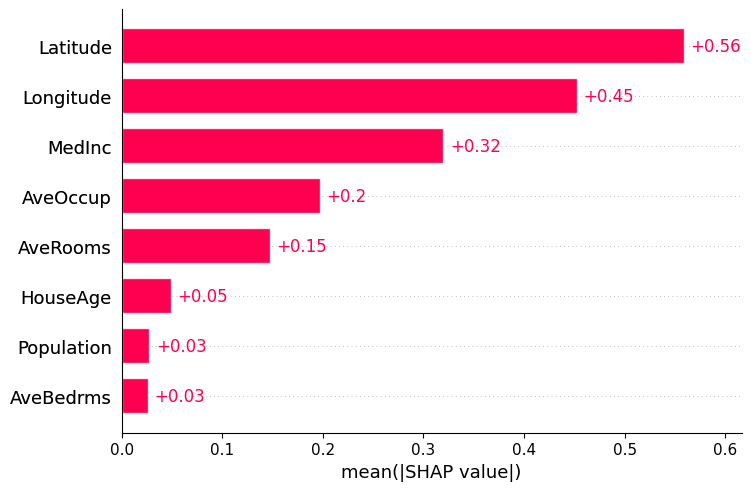

In [ ]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [ ]:
shap_values[0:3].abs.mean(axis=0).values

array([0.29395211, 0.13146125, 0.08102568, 0.03941413, 0.01094649,
       0.38070249, 0.59861867, 0.46659402])

In [ ]:
shap_values.abs.mean(axis=0).values

array([0.31981015, 0.04891435, 0.14732617, 0.02628781, 0.02762764,
       0.19686171, 0.55901175, 0.45227005])

In [ ]:
list(zip(feature_names,shap_values.abs.mean(axis=0).values))

[('MedInc', np.float64(0.3198101484521827)),
 ('HouseAge', np.float64(0.04891434543846917)),
 ('AveRooms', np.float64(0.14732617075195176)),
 ('AveBedrms', np.float64(0.026287812396545075)),
 ('Population', np.float64(0.027627640325723117)),
 ('AveOccup', np.float64(0.19686171294428548)),
 ('Latitude', np.float64(0.5590117541451175)),
 ('Longitude', np.float64(0.4522700522813813))]

In [ ]:
feature_importances = {feature:shap_val.item() for feature, shap_val in 
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [ ]:
feature_importances

{'MedInc': 0.3198101484521827,
 'HouseAge': 0.04891434543846917,
 'AveRooms': 0.14732617075195176,
 'AveBedrms': 0.026287812396545075,
 'Population': 0.027627640325723117,
 'AveOccup': 0.19686171294428548,
 'Latitude': 0.5590117541451175,
 'Longitude': 0.4522700522813813}

In [ ]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'Population',
 'AveBedrms']

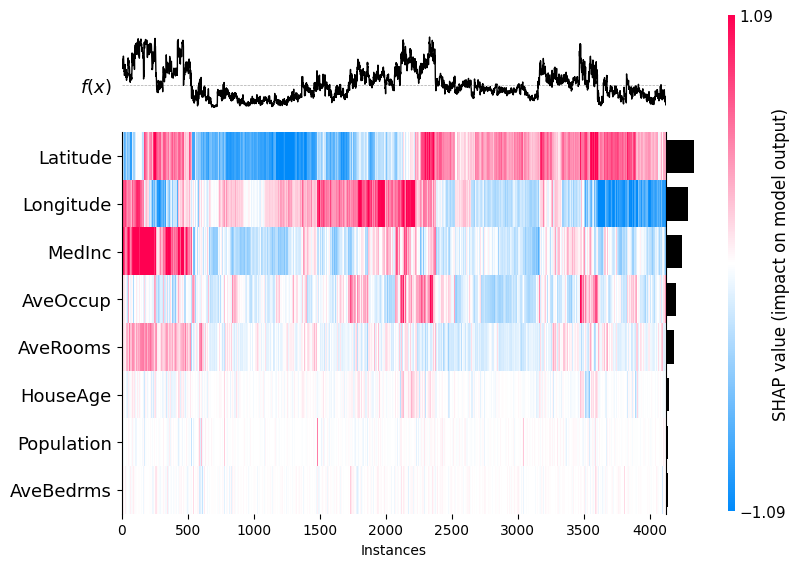

<Axes: xlabel='Instances'>

In [30]:
# heatmap plot

shap.plots.heatmap(shap_values)

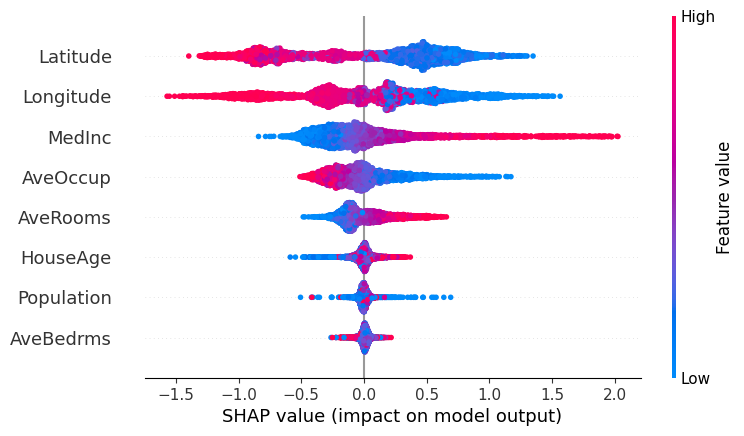

In [31]:
# summary plot

shap.plots.beeswarm(shap_values)

In [31]:
shap_values[:, "MedInc"]

.values =
array([-0.40922965, -0.31414136,  0.13484832, ...,  1.66240916,
       -0.29087492, -0.08301058], shape=(4128,))

.base_values =
array([2.01793163, 2.01793163, 2.01793163, ..., 2.01793163, 2.01793163,
       2.01793163], shape=(4128,))

.data =
array([1.6812, 2.5313, 3.4801, ..., 9.2298, 2.785 , 3.5521], shape=(4128,))

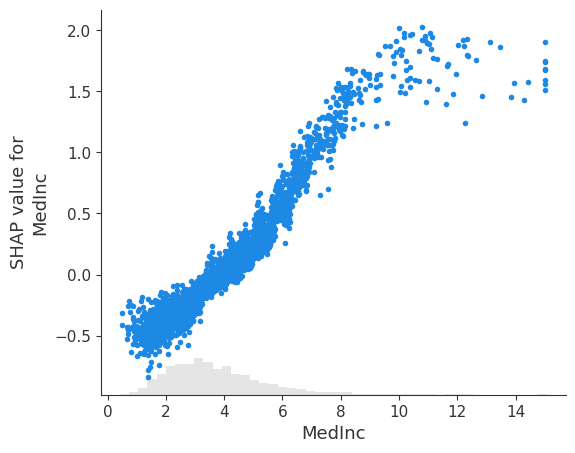

In [32]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

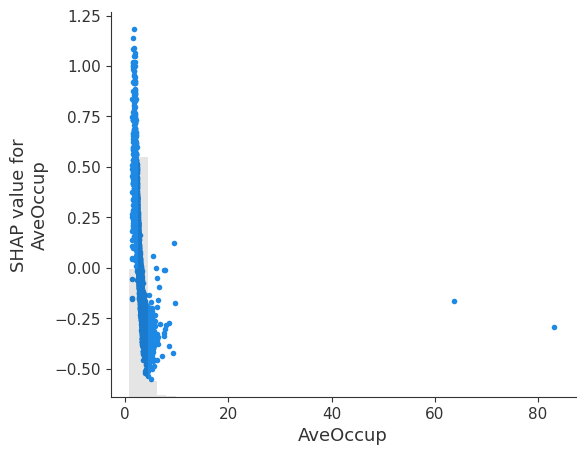

In [32]:
shap.plots.scatter(shap_values[:, "AveOccup"])

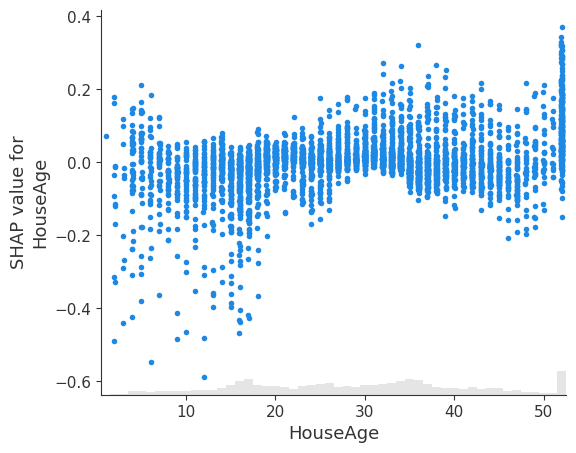

In [33]:
shap.plots.scatter(shap_values[:, "HouseAge"])

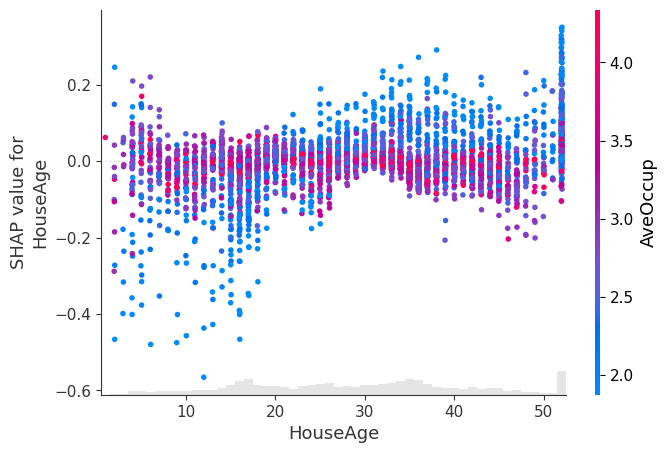

In [34]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

### LOCAL PLOTS